In [1]:
import os
import numpy as np
from skimage import io
from skimage import transform as tf
from IPython.display import Image, display
from PIL import Image, ImageEnhance

In [104]:
# example for picking an arbitrary image
for i, file in enumerate(os.listdir('data/train/ix/')):
    X = io.imread('data/train/ix/'+file)
    if i > 5:
        break

In [2]:
# augmentation functions
def shear(image, shear):
    # Create Afine transform
    afine_tf = tf.AffineTransform(shear=shear)
    # Apply transform to image data
    modified = tf.warp(image, inverse_map=afine_tf, cval=1, mode ='constant')
    
    return modified

def flip(image, axis):
    if axis == 'horizontal':
        return np.flip(image, 1)
    else:
        return np.flip(image, 0)
        
def smear(image, axis, factor):
    if axis == 'horizontal':
        # resize
        image_resized = tf.resize(image, (image.shape[0] // (factor**-1), image.shape[1]), anti_aliasing=True)
        image_rescaled = tf.rescale(image_resized, factor**-1)
        # set boundaries
        L = (image_rescaled.shape[1] // 2)-(image.shape[1] // 2)
        R = (image_rescaled.shape[1] // 2)+(image.shape[1] // 2)
        image_rescaled = image_rescaled[:, L:R]
        
    else:
        # resize
        image_resized = tf.resize(image, (image.shape[0], (image.shape[1] // (factor**-1))), anti_aliasing=True)
        image_rescaled = tf.rescale(image_resized, factor**-1)
        # set boundaries
        U = (image_rescaled.shape[0] // 2)-(image.shape[0] // 2)
        D = (image_rescaled.shape[0] // 2)+(image.shape[0] // 2)
        image_rescaled = image_rescaled[U:D, :]
        
    return image_rescaled

def rotate(image, angle):
    return tf.rotate(image, angle, cval=1)
    
def corner(image, corner, factor): # take factor portion of the image from the corner
    if corner == 'UL':
        cropped_image = image[:int(image.shape[0]*factor), :int(image.shape[1]*factor),]
        cropped_image = tf.resize(cropped_image, image.shape)
    elif corner == 'UR':
        cropped_image = image[:int(image.shape[0]*factor), int(image.shape[1]*(1-factor)):]
        cropped_image = tf.resize(cropped_image, image.shape)
    elif corner == 'DL':
        cropped_image = image[int(image.shape[0]*(1-factor)):, :int(image.shape[1]*factor),]
        cropped_image = tf.resize(cropped_image, image.shape)
    else:
        cropped_image = image[int(image.shape[0]*(1-factor)):, int(image.shape[1]*(1-factor)):]
        cropped_image = tf.resize(cropped_image, image.shape)

    return cropped_image

def composite(target, i_img):
    def last_nonzero(arr, axis, invalid_val=-1):
        mask = arr < 1
        val = arr.shape[axis] - np.flip(mask, axis=axis).argmax(axis=axis) - 1
        return np.where(mask.any(axis=axis), val, invalid_val)

    def first_nonzero(arr, axis, invalid_val=1000):
        mask = arr < 1
        return np.where(mask.any(axis=axis), mask.argmax(axis=axis), invalid_val)
    
    if target == 'ii':
        R = np.min(first_nonzero(i_img, 1))
        L = np.max(last_nonzero(i_img, 1))
        i = i_img[:, R:L]//255
        ii_image = np.hstack([np.ones((i_img.shape[0], R-i.shape[1]//2)), i, np.roll(i, -2, 0), np.ones((i_img.shape[0], i_img.shape[1]-L-i.shape[1]//2))])
        
        return ii_image
    
    if target == 'iii':
        R = np.min(first_nonzero(i_img, 1))
        L = np.max(last_nonzero(i_img, 1))
        i = i_img[:, R:L]//255
        iii_image = np.hstack([np.ones((i_img.shape[0], R-i.shape[1]//2)), i, np.roll(i, -1, 0), np.roll(i, -3, 0), np.ones((i_img.shape[0], i_img.shape[1]-L-i.shape[1]//2))])        
        
        return iii_image

def prepare_img(img): # photoshop an image to fit our dataset in terms of brightness and contrast
    # brightness
    curr_contrast = ImageEnhance.Contrast(img)
    new_contrast = 8
    img = curr_contrast.enhance(new_contrast)
    
    # contrast
    curr_brightness = ImageEnhance.Brightness(img)
    new_brightness = 4
    img = curr_brightness.enhance(new_brightness)
    
    return img

In [70]:
# photoshopping images from the added dataset
for c in ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']:
    for i, file in enumerate(os.listdir(f'HWRN/{c}/')):
        try:
            img = Image.open(f'HWRN/{c}/'+file)
            h = np.mean(img)
            if h < 100:
                continue
            img = prepare_img(img)
            img.save(f'HWRN_mod/{c}/'+file[:-4]+'_mod.png')
        except:
            continue

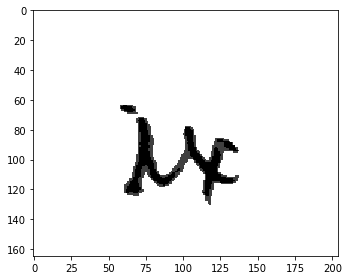

In [149]:
io.imshow(X)
io.show()

### Create augmentation directories

In [3]:
def create_dir(parent_dir, new_dir):
    path = os.path.join(parent_dir, new_dir)
    os.mkdir(path)
    return path

In [6]:
augment_dir = 'augmentations-hwrn'
# origin_dir = f'data_cleaned/train/{c}/'
# origin_dir = f'HWRN_mod/{c}/'

### Creating the datasets 
All datasets are with the following structure:

augmentation -> augmentation parameter -> classes

In [7]:
# shearing
shear_dir = create_dir(augment_dir, 'shear')
for s in [-0.2, -0.1, 0.1, 0.2]:
    mod_path = create_dir(shear_dir, f'shear_{s}')
    for c in ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']:
        c_in_mod_path = create_dir(mod_path, c)
        for i, file in enumerate(os.listdir(f'HWRN_mod/{c}/')):
            try:
                img = io.imread(f'HWRN_mod/{c}/'+file)
                img = (shear(img, s)*255).astype(np.uint8)
                sans_point = ''.join([c for c in str(s) if c != '.'])
                img_path = c_in_mod_path + '/' + file[:-4] + f'_shear_{sans_point}.png'
                io.imsave(img_path, img)
            except:
                continue

In [8]:
# smear - horizontal
mod = 'smear_h'
mod_dir = create_dir(augment_dir, mod)
for s in [0.6, 0.75]:
    s_mod_path = create_dir(mod_dir, f'{mod}_{s}')
    for c in ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']:
        c_in_mod_path = create_dir(s_mod_path, c)
        for i, file in enumerate(os.listdir(f'HWRN_mod/{c}/')):
            try:
                img = io.imread(f'HWRN_mod/{c}/'+file)
                img = (smear(img, 'horizontal', s)*255).astype(np.uint8)
                sans_point = ''.join([c for c in str(s) if c != '.'])
                img_path = c_in_mod_path + '/' + file[:-4] + f'_{mod}_{sans_point}.png'
                io.imsave(img_path, img)
            except:
                continue

In [9]:
# smear - vertical
mod = 'smear_v'
mod_dir = create_dir(augment_dir, mod)
for s in [0.6, 0.75]:
    s_mod_path = create_dir(mod_dir, f'{mod}_{s}')
    for c in ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']:
        c_in_mod_path = create_dir(s_mod_path, c)
        for i, file in enumerate(os.listdir(f'HWRN_mod/{c}/')):
            try:
                img = io.imread(f'HWRN_mod/{c}/'+file)
                img = (smear(img, 'vertical', s)*255).astype(np.uint8)
                sans_point = ''.join([c for c in str(s) if c != '.'])
                img_path = c_in_mod_path + '/' + file[:-4] + f'_{mod}_{sans_point}.png'
                io.imsave(img_path, img)
            except:
                continue

In [10]:
# rotation
mod = 'rotate'
mod_dir = create_dir(augment_dir, mod)
for s in [-15, -10, 10, 15]:
    s_mod_path = create_dir(mod_dir, f'{mod}_{s}')
    for c in ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']:
        c_in_mod_path = create_dir(s_mod_path, c)
        for i, file in enumerate(os.listdir(f'HWRN_mod/{c}/')):
            try:
                img = io.imread(f'HWRN_mod/{c}/'+file)
                img = (rotate(img, s)*255).astype(np.uint8)
                sans_point = ''.join([c for c in str(s) if c != '.'])
                img_path = c_in_mod_path + '/' + file[:-4] + f'_{mod}_{sans_point}.png'
                io.imsave(img_path, img)
            except:
                continue

In [11]:
# flip
flip_dict = {
    'horizontal': 
        {'i': 'i',
        'ii': 'ii',
        'iii': 'iii',
        'iv': 'vi',
        'v': 'v',
        'vi': 'iv',
        'x': 'x'},
    
    'vertical': 
        {'i': 'i',
        'ii': 'ii',
        'iii': 'iii',
        'ix': 'ix',
        'x': 'x'}
}

mod = 'flip'
mod_dir = create_dir(augment_dir, mod)
for s in ['horizontal', 'vertical']:
    s_mod_path = create_dir(mod_dir, f'{mod}_{s}')
    for c in flip_dict[s]:
        c_in_mod_path = create_dir(s_mod_path, flip_dict[s][c])
        for i, file in enumerate(os.listdir(f'HWRN_mod/{c}/')):
            try:
                img = io.imread(f'HWRN_mod/{c}/'+file)
                img = flip(img, s)
                sans_point = ''.join([c for c in str(s) if c != '.'])
                img_path = c_in_mod_path + '/' + file[:-4] + f'_{mod}_{sans_point}.png'
                io.imsave(img_path, img)
            except:
                continue

In [12]:
### composite
mod = 'composite'
mod_dir = create_dir(augment_dir, mod)
for s in ['i stacking']:
    s_mod_path = create_dir(mod_dir, f'{mod}_{s}')
    for c in ['ii', 'iii']:
        c_in_mod_path = create_dir(s_mod_path, c)
        for i, file in enumerate(os.listdir(f'data_cleaned/train/i/')):
            try:
                img = io.imread(f'data_cleaned/train/i/'+file)
                img = (composite(c, img)*255).astype(np.uint8)
                if img.shape[1] / img.shape[0] > 2:
                    continue
                sans_point = ''.join([c for c in str(s) if c != '.'])
                img_path = c_in_mod_path + '/' + file[:-4] + f'_{mod}_{sans_point}.png'
                io.imsave(img_path, img)
            except:
                continue

/tmp/ipykernel_29784/101927493.py:16: UserWarning: augmentations-hwrn/composite/composite_i stacking/ii/ac64aa4e-ce5d-11eb-b317-38f9d35ea60f_composite_i stacking.png is a low contrast image
  io.imsave(img_path, img)


In [13]:
'''
    For the given path, get the List of all files in the directory tree 
'''
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

len(getListOfFiles(augment_dir))

31022